In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [5]:
X_train.shape, y_train.shape

((55000, 28, 28), (55000,))

In [6]:
X_test.shape, y_test.shape

((10000, 28, 28), (10000,))

In [7]:
X_valid.shape, y_valid.shape

((5000, 28, 28), (5000,))

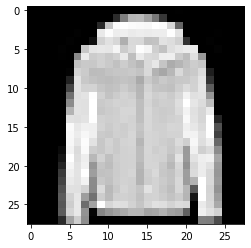

In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap='gray')

In [9]:
y_train[0]

4

In [10]:
import numpy as np

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
# split into train, test and validation set - DONE
# shuffle the train set - DONE
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

(28, 28) tf.Tensor(2, shape=(), dtype=uint8)
tf.Tensor(2, shape=(), dtype=uint8)


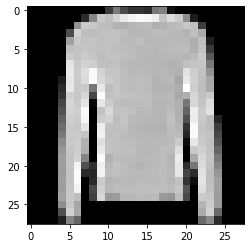

In [12]:
for image, label in train_set.take(1):
    print(image.shape, label)
    plt.imshow(image, cmap='gray')
    print(label)

In [13]:
from tensorflow.train import Feature, Features, Example

save each dataset into multiple TFRecord files where each record should be a serialized Example protobuff with two features: serialized image (use tf.io.serialize_tensor() to serialize each image), and the label. then use tf.data to create an efficient datast for each set. 

In [14]:
from tensorflow.train import BytesList, FloatList, Int64List

def create_serialized_example_protobuff(image, label):
    # first you should serialize the image - mentioned in the question
    image_data = tf.io.serialize_tensor(image)
    data_example = Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))
    return data_example

In [15]:
# ok now I have a way to convert each pair of image, label to an Example protobuff
# what next ? 
import os
from contextlib import ExitStack

def create_multiple_tfrecords_from_protobuff(dataset, name_prefix=None, n_parts=10):
    
    fashion_mnist_dir = os.path.join("datasets", "fashion_mnist")
    os.makedirs(fashion_mnist_dir, exist_ok=True)
    paths = [os.path.join(fashion_mnist_dir, "{}-{:02d}.tfrecord".format(name_prefix, index, n_parts))
             for index in range(n_parts)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_parts
            example = create_serialized_example_protobuff(image, label)
            writers[shard].write(example.SerializeToString())
    return paths


In [16]:
train_filepaths = create_multiple_tfrecords_from_protobuff(train_set, name_prefix='fashion_mnist.train_set', n_parts=10)
test_filepaths = create_multiple_tfrecords_from_protobuff(test_set, name_prefix='fashion_mnist.test_set', n_parts=10)
valid_filepaths = create_multiple_tfrecords_from_protobuff(valid_set, name_prefix='fashion_mnist.valid_set', n_parts=10)

use tf.data to create an efficient dataset for each set - basically you need to use these separate files and get back a dataset. alright let's do this.

In [17]:
def parse_serialized_example_protobuff(serialized_example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example['label']

def read_dataset_from_parsed_protobuff(filepaths, n_readers=5, n_read_threads=5,
                                        shuffle_buffer_size=None, n_parse_threads=5,
                                         batch_size=32):
    # read TFRecords and create a dataset
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    # shuffle dataset
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    # map each example in datset using the parse function
    dataset = dataset.map(parse_serialized_example_protobuff, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)    

In [18]:
train_set_new = read_dataset_from_parsed_protobuff(train_filepaths, shuffle_buffer_size=50000)
test_set_new = read_dataset_from_parsed_protobuff(test_filepaths)
valid_set_new = read_dataset_from_parsed_protobuff(valid_filepaths)

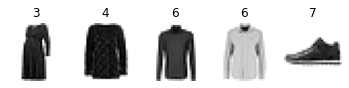

In [19]:
for X, y in train_set_new.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

use a keras model to train these datasets, including a preprocessing layer to standardize each input feature. try to make the input pipeline as efficient as possible.

ok first of all, I don't like tensorboard. second, what the heck is profiling data? 

In [21]:
class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [22]:
standardization = Standardization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

In [23]:

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [24]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('fashion_mnist_keras_model.h5',
                                               save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, 
                                                 restore_best_weights=True)

In [25]:
model.fit(train_set_new, epochs=10, validation_data=valid_set_new, 
         callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5631 - accuracy: 0.7988 - val_loss: 0.3654 - val_accuracy: 0.8692
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3385 - accuracy: 0.8791 - val_loss: 0.3472 - val_accuracy: 0.8802
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2964 - accuracy: 0.8890 - val_loss: 0.3315 - val_accuracy: 0.8790
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2709 - accuracy: 0.8983 - val_loss: 0.3673 - val_accuracy: 0.8730
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2475 - accuracy: 0.9076 - val_loss: 0.3361 - val_accuracy: 0.8838
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2363 - accuracy: 0.9114 - val_loss: 0.3310 - val_accuracy: 0.8888
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2210 - accuracy: 0.9169 - val_loss: 0.3328 - val_accuracy:

In [27]:
new_model = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Normalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
new_model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [28]:
new_model.fit(train_set_new, epochs=10, validation_data=valid_set_new, 
         callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 10.2203 - accuracy: 0.6375 - val_loss: 0.8755 - val_accuracy: 0.6924
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7327 - accuracy: 0.7184 - val_loss: 0.6637 - val_accuracy: 0.7576
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5903 - accuracy: 0.7889 - val_loss: 0.5772 - val_accuracy: 0.8154
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5334 - accuracy: 0.8140 - val_loss: 0.5209 - val_accuracy: 0.8282
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4933 - accuracy: 0.8277 - val_loss: 0.5161 - val_accuracy: 0.8408
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4679 - accuracy: 0.8398 - val_loss: 0.4976 - val_accuracy: 0.8426
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4626 - accuracy: 0.8428 - val_loss: 0.4893 - val_accuracy

In [30]:
model.evaluate(test_set_new)

313/313 [==============================] - 1s 2ms/step - loss: 0.3894 - accuracy: 0.8811


[0.38940757513046265, 0.8810999989509583]

In [31]:
new_model.evaluate(test_set_new)

313/313 [==============================] - 1s 2ms/step - loss: 0.5319 - accuracy: 0.8273


[0.5319054126739502, 0.8273000121116638]